In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile

In [ ]:
# Directory with our training cat pictures
train_cat_dir = os.path.join('drive/MyDrive/Ujian Praktik Computer Vision/train/cat')

# Directory with our training deer pictures
train_deer_dir = os.path.join('drive/MyDrive/Ujian Praktik Computer Vision/train/deer')

# Directory with our training dog pictures
train_dog_dir = os.path.join('drive/MyDrive/Ujian Praktik Computer Vision/train/dog')

# Directory with our training horse pictures
train_horse_dir = os.path.join('drive/MyDrive/Ujian Praktik Computer Vision/train/horse')

# Directory with our test pictures
test_dir = os.path.join('drive/MyDrive/Ujian Praktik Computer Vision/test/test')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
image_datagen = ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                   width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True, validation_split=0.2)

# Flow training images in batches of 120 using train_datagen generator
train_generator = image_datagen.flow_from_directory(
        'drive/MyDrive/Ujian Praktik Computer Vision/train/',  # This is the source directory for training images
        #classes = ['cat', 'deer', 'dog', 'horse'],
        subset= 'training',
        target_size=(224, 224),  # All images will be resized to 200x200
        batch_size=32)
        # Use binary labels
        #class_mode='binary')

# Flow test images in batches of 19 using validation_datagen generator
test_generator = image_datagen.flow_from_directory(
        'drive/MyDrive/Ujian Praktik Computer Vision/train/',  # This is the source directory for training images
        #classes = ['cat', 'deer', 'dog', 'horse'],
        subset= 'validation',
        target_size=(224, 224),  # All images will be resized to 200x200
        batch_size=32)
        # Use binary labels
        #class_mode='binary',
        #shuffle=False)

Found 2240 images belonging to 4 classes.
Found 560 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
from keras.applications import vgg16, resnet

In [ ]:
#base model

base_model_1 = resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model_1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras import activations

In [ ]:
# lets add the final layers to our base model
model_1 = Sequential()
model_1.add(base_model_1)
model_1.add(Flatten())

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#Add Dense Layer
model_1.add(Dense(128, activation=activations.relu))

model_1.add(Dropout(0.6))
model_1.add(Dense(4, activation='softmax'))
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 36,433,412
Trainable params: 36,380,292
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model_1.compile(loss='categorical_crossentropy', # untuk multi class classifcation
              optimizer='sgd', # optimizer -> update bobot
              metrics='accuracy' # evaluasi matrics
              )
checkpoint_filepath = '/content/best_model_vgg'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = model_1.fit(
    train_generator, #prepared data
    batch_size = 70,
    epochs=10,
    validation_data=test_generator,
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
70/70 [==============================] - 1741s 25s/step - loss: 1.6010 - accuracy: 0.6763 - val_loss: 1.9384 - val_accuracy: 0.2500
Epoch 2/10
70/70 [==============================] - 53s 750ms/step - loss: 0.3678 - accuracy: 0.8607 - val_loss: 4.9264 - val_accuracy: 0.3179
Epoch 3/10
70/70 [==============================] - 53s 757ms/step - loss: 0.2810 - accuracy: 0.8978 - val_loss: 2.0859 - val_accuracy: 0.2357
Epoch 4/10
70/70 [==============================] - 53s 750ms/step - loss: 0.2221 - accuracy: 0.9272 - val_loss: 1.5690 - val_accuracy: 0.3250
Epoch 5/10
70/70 [==============================] - 52s 746ms/step - loss: 0.1867 - accuracy: 0.9357 - val_loss: 1.5570 - val_accuracy: 0.3018
Epoch 6/10
70/70 [==============================] - 52s 747ms/step - loss: 0.1626 - accuracy: 0.9491 - val_loss: 1.6530 - val_accuracy: 0.3339
Epoch 7/10
70/70 [==============================] - 53s 749ms/step - loss: 0.1142 - accuracy: 0.9589 - val_loss: 1.2993 - val_accuracy: 0.3804

18/18 [==============================] - 12s 611ms/step - loss: 0.8873 - accuracy: 0.7179


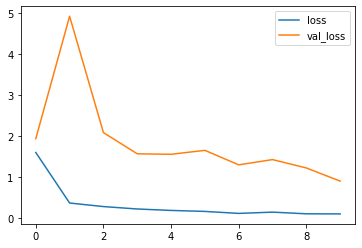

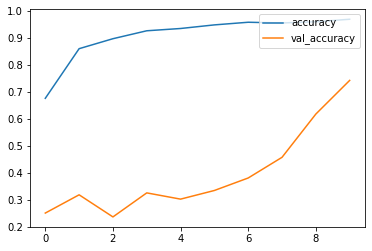

In [ ]:
#pretrained model dari ImageNet dengan Arsiketur VGG16
import matplotlib.pyplot as plt
model_1.evaluate(test_generator)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()